In [1]:
from tqdm import tqdm
from cuml import KMeans
from skimage.metrics import hausdorff_distance
from skimage.measure import perimeter
from sklearn.metrics import f1_score
from utils import *
from skimage.morphology import binary_closing, binary_opening
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings


warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [2]:
test_results = pd.read_csv(
    'final_results.csv', index_col=0)
test_results.sort_values('kmeans_dsc')[['kmeans_dsc']]


,kmeans_dsc
patients,
128,0.000000
63,0.000085
286,0.016094
142,0.065969
146,0.127442
61,0.177810
365,0.223831
209,0.239814
109,0.279574


In [3]:
validation_set = [67, 107,  89, 276, 109, 199, 352,  51, 326, 165,  92, 286, 244,
                  142, 281, 132, 365, 176, 128, 333,  63, 209, 191, 164, 106,  61,
                  120, 259, 263, 146]

test_patient = 142
training_set = True

if training_set:
    brats_path = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
    dataset_part = "_Training_"
else:
    brats_path = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'
    dataset_part = "_Validation_"


In [11]:
def extract_features_kmeans(patient_scans, slice):
    X = np.stack([patient_scans[i][:, :, slice].flatten()
                 for i in range(1, len(patient_scans))]).T
    return X


def two_roundest_segmented_regions(model, slice_features):
    """Returns segmentation masks for 2 most round segmented regions

    Args:
        model (sklearn.model): KMeans model to fit the data
        slice_features (np.ndarray(n_piels, n_features)): Feature descrbing pixels flattened to a matrix

    Returns:
        list[np.ndarray(240, 240)]: Segmentation masks corresponding for 2 most round regions
    """
    model.fit(slice_features)
    final_mask = model.predict(slice_features).reshape(240, 240)
    circularity_scores = [np.abs(1 - perimeter(final_mask == cls)
                                 ** 2/(4*np.pi*(final_mask == cls).sum())) for cls in range(5)]
    return [(final_mask == tumor_cand).astype(int) for tumor_cand in np.argsort(circularity_scores)[:2]]


def evaluate_patient_KMeans(model, patient_data, max_tumor_prc=0.34):
    predicted_tumor_mask = np.zeros(patient_data[0, 0].shape)

    for slice_idx in range(patient_data[0, 0].shape[-1]):

        slice_features = extract_features_kmeans(patient_data[0], slice_idx)
        predicted_tumor_slice = np.zeros(patient_data[0, 0, :, :, slice_idx].shape)

        for predicted_tumor_slice_cand in two_roundest_segmented_regions(model, slice_features):
            # check if candidate region is not in the background and has a meaningfull size
            if ((patient_data[0, 1, :, :, slice_idx] == 0) & (predicted_tumor_slice_cand)).sum() == 0 and predicted_tumor_slice_cand.sum()/((patient_data[0, 1, :, :, slice_idx] > 0).sum()) < max_tumor_prc:
                predicted_tumor_slice = predicted_tumor_slice_cand
        
        predicted_tumor_mask[:, :, slice_idx] = predicted_tumor_slice
    return predicted_tumor_mask


In [12]:
patient_data = retrieve_brats_data([test_patient], ['t1', 't2', 't1ce', 'flair'], dataset_part=dataset_part, brats_path=brats_path)
kmeans = KMeans(n_clusters=5)
result_mask = evaluate_patient_KMeans(kmeans, patient_data)


In [13]:
result_mask = binary_closing(binary_opening(result_mask))

In [14]:
print("Dice score: ", dice_score(result_mask, patient_data[0, 0]))
print("Hausdorf distance: ", hausdorff_distance(
    result_mask, patient_data[0, 0]))


Dice score:  0.049715279435332625
Hausdorf distance:  100.78194282707592


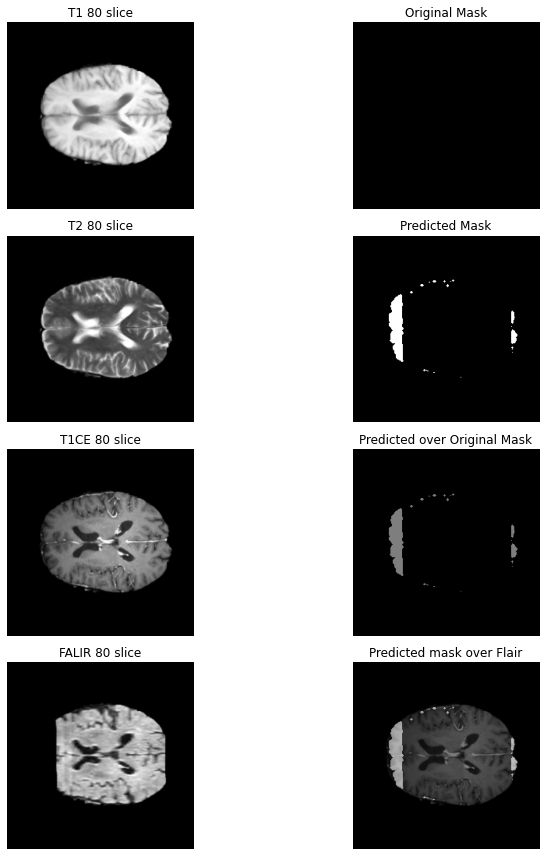

In [16]:
plot_results(patient_data, result_mask, 80)
# plot_results_for_validation(patient_data, result_mask, 80)

# Testing All

<AxesSubplot:xlabel='patients'>

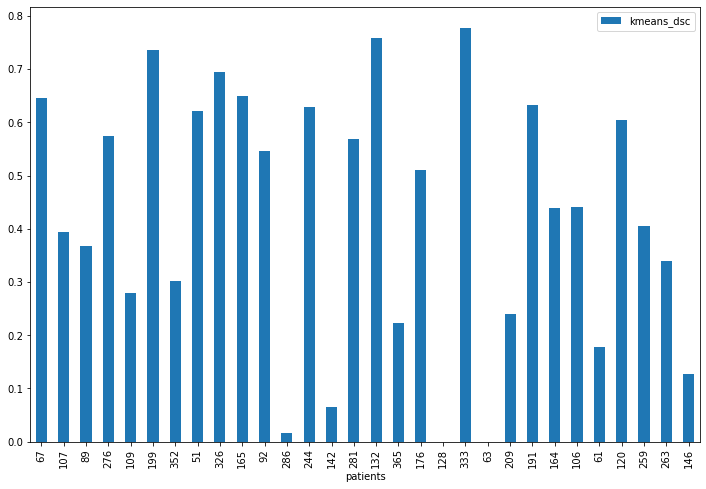

In [64]:
test_results[['kmeans_dsc']].plot.bar(figsize=(12,8))

<AxesSubplot:>

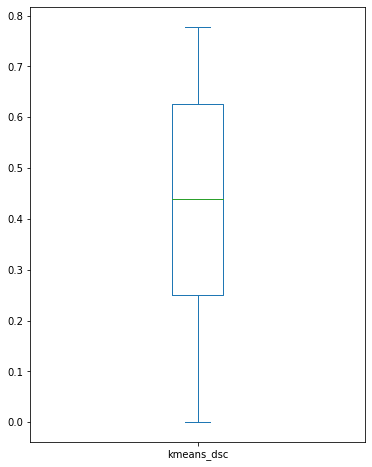

In [66]:
test_results[['kmeans_dsc']].plot.box(figsize=(6,8))

In [67]:
print(test_results['kmeans_dsc'].mean(), '+-', test_results['kmeans_dsc'].std())

0.4255790613440719 +- 0.238941277934375
